In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd
from torch import optim
import torchvision.models as torch_models

In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.core.master_bar, fastai.core.progress_bar = master_bar, progress_bar

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_WyRytb0.csv')
hard = pd.read_csv('../data/hard.csv')

In [4]:
hard_train = train.merge(hard[['image_name']], on='image_name')

resample_time = 10
for i in range(resample_time):
    train = pd.concat([train, hard_train])
train = train.sample(frac=1.0)

In [5]:
name = f'resnet101_7'

In [6]:
SZ = 256
BS = 32
NUM_WORKERS = 0
SEED = 7

In [7]:
xtra_tfms = [crop(size=256, row_pct=(0.3, 0.7), col_pct=(0.4,0.6), p=.3), 
             jitter(magnitude=(0.00, 0.005), p=0.3),
             rand_zoom(scale=(0.8, 1.2), p=0.3), 
             perspective_warp(magnitude=(0.0, 0.1), p=0.3),
             tilt(direction=(0,3), magnitude=(-0.1, 0.1), p=0.3),
             squish(scale=(0.9, 1.1), row_pct=(0.0, 0.1), col_pct=(0.0, 0.1), p=0.3),
             skew(direction=(0,7), magnitude=(0.0, 0.1), p=0.3),
             cutout(n_holes=(1,2), length=(10, 60), p=.3)]

data = (
    ImageList
        .from_df(train, '../data/train', cols=['image_name'])
        .split_by_rand_pct(valid_pct=0.1, seed=SEED)
        .label_from_df(cols='label')
        .add_test(ImageList.from_df(test, '../data/train'))
        .transform(get_transforms(do_flip=True, flip_vert=False,  max_rotate=15.0, max_zoom=1.0, 
                                  max_lighting=0.05, max_warp=0.05, p_affine=0.05, p_lighting=0.05, xtra_tfms=xtra_tfms),
                   size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='../data')
        .normalize(imagenet_stats)
)

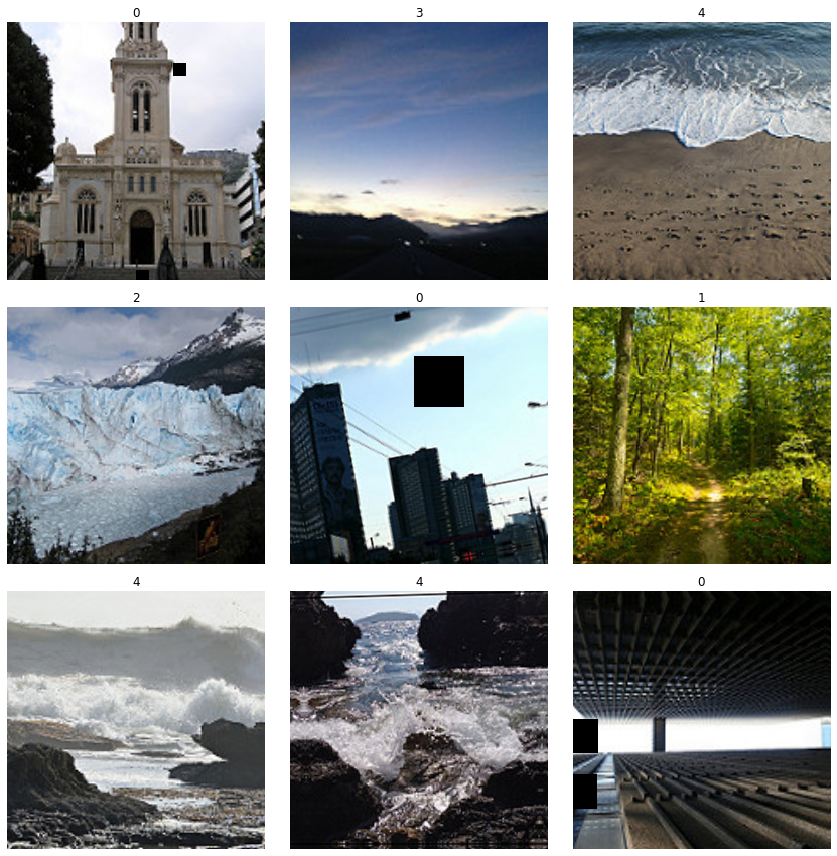

In [8]:
data.show_batch(rows=3)

In [9]:
%%time
learn = cnn_learner(data, models.resnet101, lin_ftrs=[2048], metrics=[accuracy])
learn.clip_grad();

# max_lr = 3e-4
# lrs = [max_lr/100, max_lr/10, max_lr]
learn.unfreeze()
learn.fit_one_cycle(35, 1e-5)                                             
learn.save(f'{name}-stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.612045,1.174247,0.596622,09:55
1,0.929619,0.611876,0.792350,10:18
2,0.551108,0.366582,0.870343,10:18
3,0.394610,0.256577,0.903626,09:29
4,0.327244,0.199681,0.931942,10:09
5,0.231827,0.157952,0.941878,09:27
6,0.216437,0.152807,0.949826,10:08
7,0.182292,0.156023,0.953304,10:10
8,0.143530,0.155289,0.955291,09:17
9,0.128376,0.162856,0.954794,10:09


Wall time: 5h 37min 9s


In [10]:
learn = cnn_learner(data, models.resnet101, lin_ftrs=[2048])
learn.load(f'{name}-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (18121 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,5,2,0
Path: ..\data\train;

Valid: LabelList (2013 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
3,1,1,2,3
Path: ..\data\train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ..\data\train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel

In [15]:
probs, _ = learn.TTA(beta=0.4, scale=1.35, ds_type=DatasetType.Test, with_loss=False)

In [16]:
np.save('resnet101_7', probs)

In [17]:
test['label'] = probs.numpy().argmax(axis=1)
test.to_csv('resnet101_mixup_wi_tta_7.csv', index=None)

In [18]:
probs = np.zeros((7301, 6))

import os

for fname in os.listdir('./'):
    if '.npy' in fname:
        probs += np.load(fname)
        
pred0  = np.load('resnet101_0.npy')
pred1  = np.load('resnet101_1.npy')
pred2  = np.load('resnet101_2.npy')
pred3  = np.load('resnet101_3.npy')
pred4  = np.load('resnet101_4.npy')
pred5  = np.load('resnet101_5.npy')
pred6  = np.load('resnet101_6.npy')
pred7  = np.load('resnet101_7.npy')

resnet_ensemble = np.load('resnet50_ensemble.npy')

probs = 0.2*(0.3*pred0 + 0.1*pred1 + 0.1*pred2+0.0*pred3+0.5*pred4) + 0.8*(resnet_ensemble/10)

In [23]:
sub = pd.DataFrame()
sub['image_name'] = test['image_name']

sub['pred7'] = resnet_ensemble.argmax(axis=1)
sub['pred4'] = pred4.argmax(axis=1)
sub['pred6'] = pred6.argmax(axis=1)
# sub['pred7'] = pred6.argmax(axis=1)

sub['pred0'] = pred0.argmax(axis=1)
sub['pred1'] = pred1.argmax(axis=1)
sub['pred2'] = pred2.argmax(axis=1)
sub['pred3'] = pred3.argmax(axis=1)
sub['pred5'] = pred5.argmax(axis=1)
pred_cols = ['pred{}'.format(i) for i in range(8)]

In [24]:
sub['label'] = sub[pred_cols].mode(axis=1)[0]
sub[['image_name', 'label']].to_csv('voting.csv', index=None)

In [43]:
prob_cols = ['prob{}'.format(i+1) for i in range(6)]
df = pd.DataFrame(probs, columns=prob_cols)
df['image_name'] = test['image_name']

In [44]:
df['prob_max'] = df[prob_cols].max(axis=1)

In [45]:
df.loc[df.prob_max<0.5, :].to_csv('test_hard.csv', index=None)

In [46]:
test['label'] = probs.argmax(axis=1)

In [47]:
test.to_csv('ensemble.csv', index=None)

In [5]:
SZ = 150
BS = 64
NUM_WORKERS = 0
SEED=731

In [6]:
xtra_tfms = [rand_crop(p=0.1),jitter(magnitude=(0.00, 0.003),p=0.1),rand_zoom(scale=(0.8, 1.2), p=0.1), 
             perspective_warp(magnitude=(0.0, 0.3), p=0.1),tilt(direction=(0,3),magnitude=(-0.2,0.2), p=0.1),
             squish(scale=(0.8, 1.2),row_pct=(0.0,0.2),col_pct=(0.0,0.2),p=0.1),skew(direction=(0,7),magnitude=(0.0,0.2), p=0.1)]

data = (
    ImageList
        .from_df(train, '../data/train', cols=['image_name'])
        .split_by_rand_pct(valid_pct=0.1, seed=SEED) 
        .label_from_df(cols='label')
        .add_test(ImageList.from_df(test, '../data/train'))
        .transform(get_transforms(do_flip=True, flip_vert=False,  max_rotate=15.0, max_zoom=1.2, 
                                  max_lighting=0.1, max_warp=0.1, p_affine=0.1, p_lighting=0.1, xtra_tfms=xtra_tfms),
                   size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='../data')
        .normalize(imagenet_stats)
)

In [7]:
%%time
learn = cnn_learner(data, models.resnet101, lin_ftrs=[2048], metrics=[accuracy]).mixup(alpha=0.97)
learn.clip_grad()
learn.load(f'{name}-stage-2')
learn.freeze_to(-13)

learn.fit_one_cycle(10, 1e-3)
learn.save(f'{name}-stage-3')
learn.unfreeze()

max_lr = 3e-3
lrs = [max_lr/9, max_lr/3, max_lr]

learn.fit_one_cycle(50, lrs)
learn.save(f'{name}-stage-4')

epoch     train_loss  valid_loss  accuracy  time    
0         0.684857    0.383707    0.930710  03:27     
1         0.738099    0.405533    0.923664  02:44     
2         0.800562    0.446237    0.912507  02:44     
3         0.800458    0.467955    0.897827  02:43     
4         0.794330    0.400465    0.920728  02:45     
5         0.758537    0.386331    0.921315  02:44     
6         0.745395    0.385891    0.928362  02:48     
7         0.721495    0.357076    0.931298  02:48     
8         0.700471    0.361949    0.934234  02:49     
9         0.703820    0.380638    0.931298  02:48     
Total time: 28:24
epoch     train_loss  valid_loss  accuracy  time    
0         0.702896    0.415559    0.918967  02:47     
1         0.696499    0.358198    0.937757  02:47     
2         0.696179    0.371185    0.928362  02:50     
3         0.708518    0.378139    0.934821  02:47     
4         0.704907    0.397014    0.930710  02:47     
5         0.703203    0.371832    0.933647  02:47  